In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer

### Data Understanding

In [3]:
df = pd.read_csv('hexawing_data.csv', encoding='latin-1')
df.head()

,Ref,id,Gender,Satisfied,Age,Age Band,Type of Travel,Class,Flight Distance,Destination,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,0,70172,Male,Y,13,Under 18,Personal Travel,Eco Plus,4760,India,...,5,5,4,3,4,4,5,5,25,18.0
1,1,5047,Male,N,25,25 to 34,Business travel,Business,235,Republic of Ireland,...,1,1,1,5,3,1,4,1,1,6.0
2,2,110028,Female,Y,26,25 to 34,Business travel,Business,4760,India,...,5,5,4,3,4,4,4,5,0,0.0
3,3,24026,Female,Y,25,25 to 34,Business travel,Business,560,Norway,...,2,2,2,5,3,1,4,2,11,9.0
4,4,119299,Male,Y,61,55 to 64,Business travel,Business,4760,India,...,5,3,3,4,4,3,3,3,0,0.0


In [4]:
df.isnull().sum()

Ref                                    0
id                                     0
Gender                                 0
Satisfied                              0
Age                                    0
Age Band                               0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Destination                            0
Continent                              0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness     

In [5]:
## we have some missing values in `ARRIVAL DELAY` so we need to use the mean value for that feature to fill up the empty cells
mean_value =df['Arrival Delay in Minutes'].mean()
print(mean_value)

15.181274977315288


In [6]:
df['Arrival Delay in Minutes'] = df['Arrival Delay in Minutes'].fillna(mean_value.astype(float))
#df.isnull().sum()

In [7]:
df.head()

,Ref,id,Gender,Satisfied,Age,Age Band,Type of Travel,Class,Flight Distance,Destination,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,0,70172,Male,Y,13,Under 18,Personal Travel,Eco Plus,4760,India,...,5,5,4,3,4,4,5,5,25,18.0
1,1,5047,Male,N,25,25 to 34,Business travel,Business,235,Republic of Ireland,...,1,1,1,5,3,1,4,1,1,6.0
2,2,110028,Female,Y,26,25 to 34,Business travel,Business,4760,India,...,5,5,4,3,4,4,4,5,0,0.0
3,3,24026,Female,Y,25,25 to 34,Business travel,Business,560,Norway,...,2,2,2,5,3,1,4,2,11,9.0
4,4,119299,Male,Y,61,55 to 64,Business travel,Business,4760,India,...,5,3,3,4,4,3,3,3,0,0.0


Satisfied
Y    84920
N    18984
Name: count, dtype: int64
Satisfied
Y    81.729289
N    18.270711
Name: proportion, dtype: float64


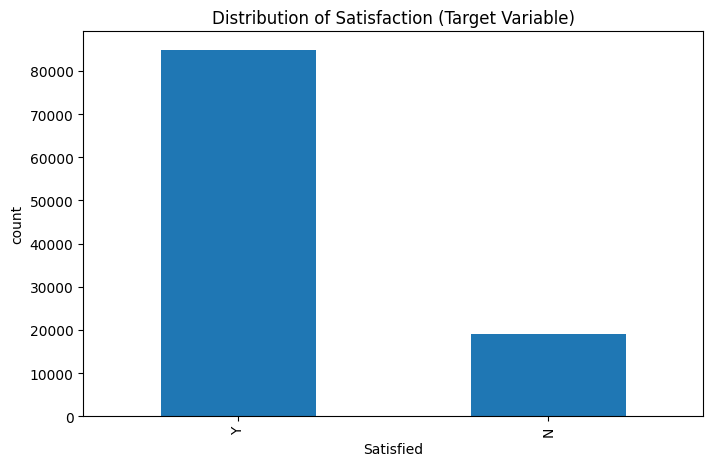

In [8]:
print(df['Satisfied'].value_counts())
print(df['Satisfied'].value_counts(normalize=True)*100)

plt.figure(figsize=(8,5))
df['Satisfied'].value_counts().plot(kind='bar')
plt.title('Distribution of Satisfaction (Target Variable)')
plt.xlabel('Satisfied')
plt.ylabel('count')
plt.show()

Based on the chart, there is a moderate class imbalance i.e the ratio of satisfied customer to not satisfied customer is 82:18.
there will be no need to class weight

Text(0.5, 1.0, 'Satisfaction by Type of Travel')

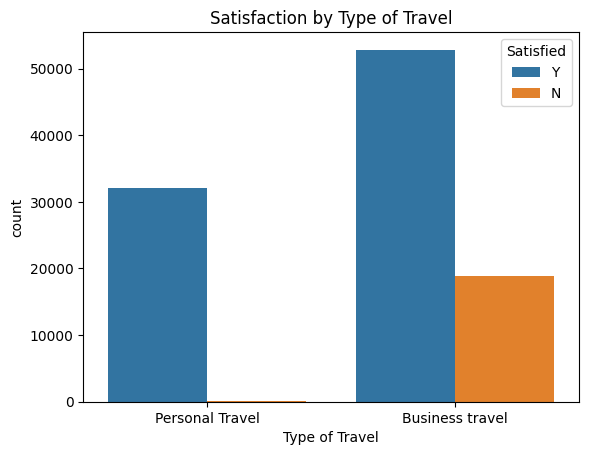

In [9]:
# plot of Satisfaction by Type of Travel

sns.countplot(x='Type of Travel', hue='Satisfied', data=df)
plt.title('Satisfaction by Type of Travel')

This grouped bar chart visualizes how passenger satisfaction varies across different types of travel (e.g., Personal vs. Business).

Insights:

Business travelers show a much higher level of satisfaction than personal travelers.

The disparity suggests that factors like comfort, convenience, and service expectations may differ between the two groups, influencing overall satisfaction.

This variable is likely to be an important predictor in the model.

Text(0.5, 1.0, 'Satisfaction by Travel Class')

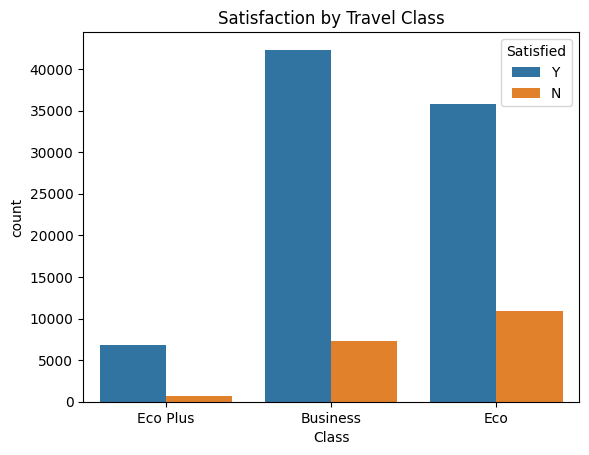

In [10]:
# Plot of Satisfaction by Travel Class

sns.countplot(x='Class', hue='Satisfied', data=df)
plt.title('Satisfaction by Travel Class')

This chart compares satisfaction levels across travel classes (Economy, Economy Plus, and Business).

Insights:

Business class passengers are the most satisfied, while Economy class passengers report more dissatisfaction.

This relationship highlights how service quality, comfort, and personalized experience strongly correlate with satisfaction.

The pattern reinforces that Class is a key feature affecting customer experience.

### Feature Engineering

In [11]:
target = 'Satisfied'
features =['Gender', 'Age', 'Type of Travel', 'Class', 'Continent', 'Flight Distance','Departure Delay in Minutes', 'Arrival Delay in Minutes']

X = df[features]
y = df[target].map({'Y': 1, 'N': 0})

### Splitting and Encoding Strategy

In [12]:
# First split: train vs test
X_full_train, X_test, y_full_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Second split: train vs validation
X_train, X_val, y_train, y_val = train_test_split(
    X_full_train,
    y_full_train,
    test_size=0.25,
    stratify=y_full_train,
    random_state=42
)

My Target column(Satisfied) is imbalanced 82/15 so Stratification was applied to ensure that the proportion of satisfied and dissatisfied passengers remained consistent across the training, validation, and test sets, enabling fair learning and reliable model evaluation on an imbalanced dataset.

### Mutual Info Score

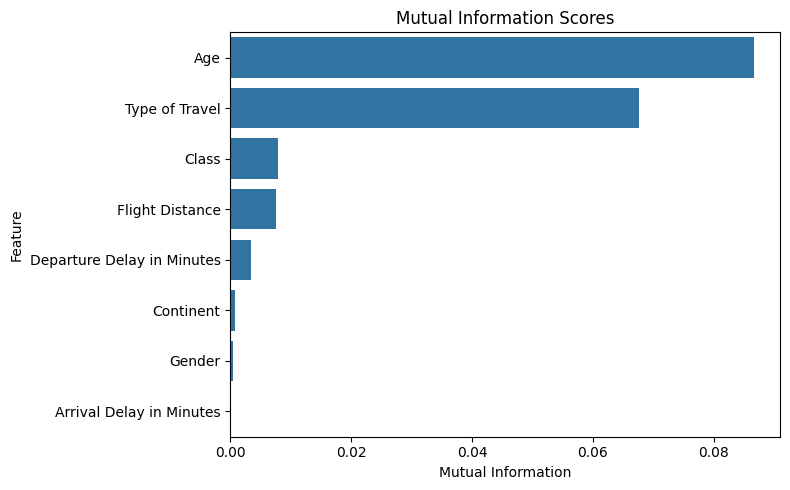

In [13]:
# 1. Copy training data only (no leakage)
X_mi = X_train.copy()
y_mi = y_train.copy()

# 2. Encode categorical features explicitly
for col in X_mi.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_mi[col] = le.fit_transform(X_mi[col])

# 3. Define which features are discrete
discrete_mask = [
    True if X_mi[col].dtype in ['int64', 'int32'] else False
    for col in X_mi.columns
]

# 4. Compute Mutual Information on training data only
mi_scores = mutual_info_classif(
    X_mi,
    y_mi,
    discrete_features=discrete_mask,
    random_state=42
)

# 5. Put results in a Series and sort
mi_series = pd.Series(mi_scores, index=X_mi.columns).sort_values(ascending=False)

# 6. Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=mi_series.values, y=mi_series.index)
plt.title("Mutual Information Scores")
plt.xlabel("Mutual Information")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Discrete feature definition prevents the algorithm from inventing fake numeric meaning where none exists.
It is explicitly identified to ensure that mutual information was estimated using appropriate probability assumptions for categorical and continuous variables.

### Vectorize(One-hot encode) features

In [14]:
dv = DictVectorizer(sparse=True)

train_dicts = X_train.to_dict(orient='records')
val_dicts   = X_val.to_dict(orient='records')

X_train_vec = dv.fit_transform(train_dicts)
X_val_vec   = dv.transform(val_dicts)

### Training on Baseline first

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(
        eval_metric='logloss',
        n_estimators=100,
        random_state=42
    )
}

results = []

for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_val_vec)

    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1  = f1_score(y_val, y_pred)

    results.append((name, acc, rec, f1))
    print(f"{name} | Accuracy: {acc:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")


Decision Tree | Accuracy: 0.845 | Recall: 0.914 | F1: 0.906
Random Forest | Accuracy: 0.871 | Recall: 0.946 | F1: 0.923
XGBoost | Accuracy: 0.882 | Recall: 0.963 | F1: 0.930


### Hyper-Parameter Tuning

Tuning the Decision Tree model

In [16]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

dt_params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

dt_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=dt_params,
    n_iter=20,
    cv=cv,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

dt_search.fit(X_train_vec, y_train)

best_model = dt_search.best_estimator_

print("Best Decision Tree Params:", dt_search.best_params_)
print("Best CV F1 Score:", dt_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Decision Tree Params: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 7, 'criterion': 'gini'}
Best CV F1 Score: 0.9293937843049077


In [17]:
# Evaluating properly
from sklearn.metrics import classification_report

y_val_pred = best_model.predict(X_val_vec)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.78      0.48      0.60      3797
           1       0.89      0.97      0.93     16984

    accuracy                           0.88     20781
   macro avg       0.84      0.73      0.76     20781
weighted avg       0.87      0.88      0.87     20781



Tuning the Random Forest Model

In [18]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_params,
    n_iter=25,
    cv=cv,
    scoring='f1',
    random_state=42,
    n_jobs=2,
    verbose=2
)

rf_search.fit(X_train_vec, y_train)

best_model = rf_search.best_estimator_

print("Best Random Forest Params:", rf_search.best_params_)
print("Best CV F1 Score:", rf_search.best_score_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


c:\Users\user\Capstone Project\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Random Forest Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': False}
Best CV F1 Score: 0.9300551762668962


In [24]:
y_val_pred = best_model.predict(X_val_vec)
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

           0       0.84      0.44      0.58      3797
           1       0.89      0.98      0.93     16984

    accuracy                           0.88     20781
   macro avg       0.87      0.71      0.76     20781
weighted avg       0.88      0.88      0.87     20781



Tuning using XGBOOST

In [20]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42
    ),
    param_distributions=xgb_params,
    n_iter=30,
    cv=cv,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

xgb_search.fit(X_train_vec, y_train)

best_model = xgb_search.best_estimator_

print("Best XGBoost Params:", xgb_search.best_params_)
print("Best CV F1 Score:", xgb_search.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best XGBoost Params: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}
Best CV F1 Score: 0.93046901325901


In [21]:
# Evaluate properly on validation
y_val_pred = best_model.predict(X_val_vec)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.83      0.45      0.58      3797
           1       0.89      0.98      0.93     16984

    accuracy                           0.88     20781
   macro avg       0.86      0.71      0.76     20781
weighted avg       0.88      0.88      0.87     20781



Comparing the tuned model on validation dataset

In [22]:
tuned_models = {
    'Decision Tree': dt_search.best_estimator_,
    'Random Forest': rf_search.best_estimator_,
    'XGBoost': xgb_search.best_estimator_
}

for name, model in tuned_models.items():
    y_pred = model.predict(X_val_vec)

    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1  = f1_score(y_val, y_pred)

    print(f"{name} | Accuracy: {acc:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")


Decision Tree | Accuracy: 0.881 | Recall: 0.970 | F1: 0.930
Random Forest | Accuracy: 0.881 | Recall: 0.974 | F1: 0.930
XGBoost | Accuracy: 0.883 | Recall: 0.980 | F1: 0.932


Retrain on Full Training Data

In [ ]:
# 1. Combine train + validation (features and target)
X_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = pd.concat([y_train, y_val], axis=0)

# 2. Vectorize using training data only
dv = DictVectorizer(sparse=True)

X_full_train_vec = dv.fit_transform(
    X_full_train.to_dict(orient='records')
)

X_test_vec = dv.transform(
    X_test.to_dict(orient='records')
)

# 3. Retrain final model on full training data
best_model.fit(X_full_train_vec, y_full_train)

# 4. Final evaluation on test set 
y_test_pred = best_model.predict(X_test_vec)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.44      0.58      3797
           1       0.89      0.98      0.93     16984

    accuracy                           0.88     20781
   macro avg       0.86      0.71      0.75     20781
weighted avg       0.88      0.88      0.87     20781

